In [8]:
import networkx
import math
import random
import statistics
import copy
import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm 
import pickle
import warnings
from scipy.spatial import distance
from sklearn.metrics import roc_auc_score
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", DeprecationWarning)

In [9]:
Graph_1 = networkx.Graph()

#Reading the edge list of Graph_2 and adding the edges
fp = open("fb-pages-food.edges", "r")
text = fp.read()
list_lines = text.split("\n")

list_edges = [a.split(',') for a in list_lines]
for a in list_edges:
    Graph_1.add_edge(a[0], a[1])
list_edges = list(Graph_1.edges())
list_nodes = list(Graph_1.nodes())
count_edges = Graph_1.number_of_edges()
list_index_edge = [b for b in range(count_edges)]
set_list_index_edge = set(list_index_edge)

# print(count_edges)
# print(list_edges)

In [10]:
Graph_1_rem = networkx.Graph()
list_avg_auc_roc = [[] for cc in range(4)]

def do_10_fold(percent):
    list_roc_auc = [[] for hh in range(4)]
    for gh in range(10):
        Graph_1_rem = networkx.Graph()

        count_remove = int((percent / 100) * count_edges)
        list_remove_index = random.sample(list_index_edge, count_remove)
        set_list_remove_index = set(list_remove_index)
        set_remaining_index = list(set_list_index_edge.difference(set_list_remove_index))
        #Adding the remaining 100 - percent% of edges
        for c in set_remaining_index:
#             curr_edge = list_edges[c]
            Graph_1_rem.add_edge(list_edges[c][0], list_edges[c][1])

        list_edges_find_index = []
        list_actual_labels = []
        #Now not taking the 75% edges present in copied graph and taking all other edges
        list_edges_copied_graph = list(Graph_1_rem.edges())
        for d in list_nodes:
            for e in list_nodes:
                if d != e:
                    if Graph_1_rem.has_node(d) and Graph_1_rem.has_node(e):
                        if Graph_1_rem.has_edge(d, e) == False:
                            list_edges_find_index.append([d, e])

        #Now finding the labels of the edges for which index is being found
        for f in list_edges_find_index:
            if Graph_1.has_edge(f[0], f[1]):
                list_actual_labels.append(1)
            else:
                list_actual_labels.append(0)

        #Finding the common neighbour index
        list_score_common_neigh = []
        for g in list_edges_find_index:
            set_neigh_1 = set([h for h in Graph_1_rem.neighbors(g[0])])
            set_neigh_2 = set([i for i in Graph_1_rem.neighbors(g[1])])
            list_score_common_neigh.append(len(set_neigh_1.intersection(set_neigh_2)))

        obtained_score = roc_auc_score(list_actual_labels,list_score_common_neigh)
        list_roc_auc[0].append(obtained_score)

        #Finding the Jaccard index based
        list_score_jaccard = []
        for j in list_edges_find_index:
            set_neigh_1 = set([k for k in Graph_1_rem.neighbors(j[0])])
            set_neigh_2 = set([l for l in Graph_1_rem.neighbors(j[1])])
            val_num = len(set_neigh_1.intersection(set_neigh_2))
            val_den = len(set_neigh_1.union(set_neigh_2))
            list_score_jaccard.append(val_num / val_den)

        obtained_score = roc_auc_score(list_actual_labels,list_score_jaccard)
        list_roc_auc[1].append(obtained_score)

        #Now finding for Adamic-Adar index
        list_score_Adamic = []
        for m in list_edges_find_index:
            set_neigh_1 = set([n for n in Graph_1_rem.neighbors(m[0])])
            set_neigh_2 = set([o for o in Graph_1_rem.neighbors(m[1])])
            set_common_neigh = list(set_neigh_1.intersection(set_neigh_2))
            sum_adamic_index = 0
            for p in set_common_neigh:
                deg_comm_neigh = Graph_1_rem.degree[p]
                sum_adamic_index = sum_adamic_index + (1 / math.log10(deg_comm_neigh))

            list_score_Adamic.append(sum_adamic_index)

        obtained_score = roc_auc_score(list_actual_labels,list_score_Adamic)
        list_roc_auc[2].append(obtained_score)

        #Now finding for preferential attachment index
        list_score_preferential = []
        for q in list_edges_find_index:
            val_deg_1 = Graph_1_rem.degree(q[0])
            val_deg_2 = Graph_1_rem.degree(q[1])
            list_score_preferential.append(val_deg_1 * val_deg_2)

        obtained_score = roc_auc_score(list_actual_labels,list_score_preferential)
        list_roc_auc[3].append(obtained_score)
    
    
#     Now finding the mean score accross 10 folds for each type of index
    for df in range(4):
        avg_score = statistics.mean(list_roc_auc[df])
        list_avg_auc_roc[df].append(avg_score)

In [18]:
list_x_cord = ['25%', '35%', '45%', '55%']
def make_plot(list_y_cord):
    plt.style.use('seaborn-darkgrid')
    plt.figure(figsize = (8,8))
#     plt.title('For Graph 1', fontsize = 16) 
    plt.plot(list_x_cord, list_y_cord, color = 'g')                               
    plt.xlabel('Percentage of edges removed', fontsize = 12)
    plt.ylabel('Average AUC-ROC score across 10 folds', fontsize = 12)
    combined_val = zip(list_x_cord, list_y_cord)
    for x_val, y_val in combined_val:
        plt.text(x_val,y_val, '({},{})'.format(x_val, y_val), fontsize = 12)
#     # plt.label("For Graph 1")
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.show()

In [ ]:
for per in range(25, 65, +10):
    do_10_fold(per)


Plot using heuristics as Common neighbours


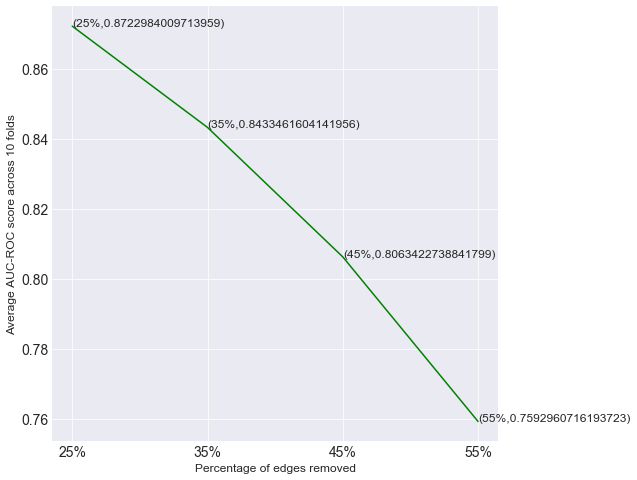


Plot using heuristics as Jaccard Index


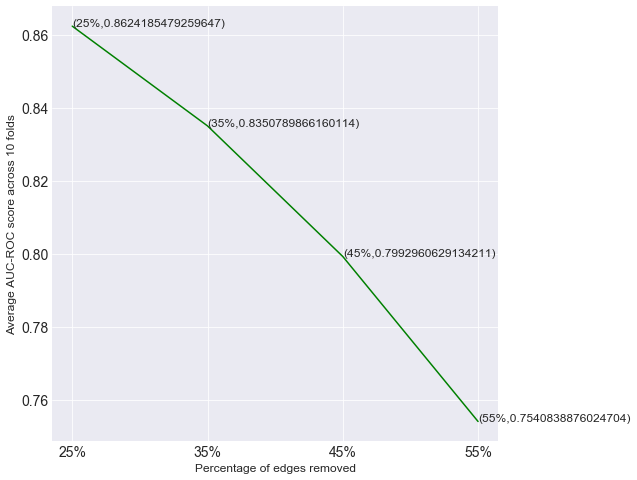


Plot using heuristics as Adamic Adar index


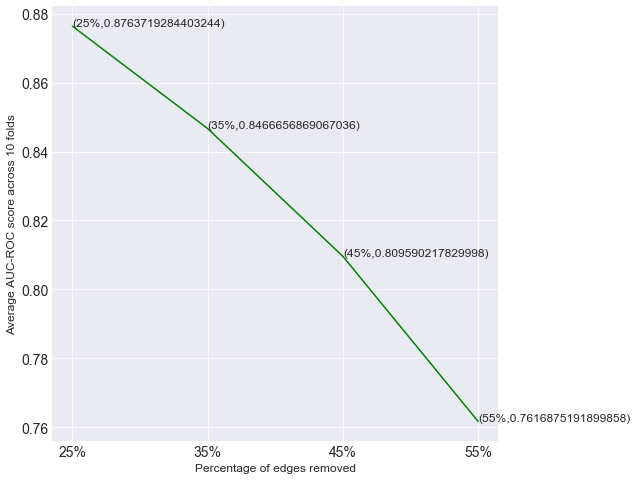


Plot using heuristics as Preferential attachment


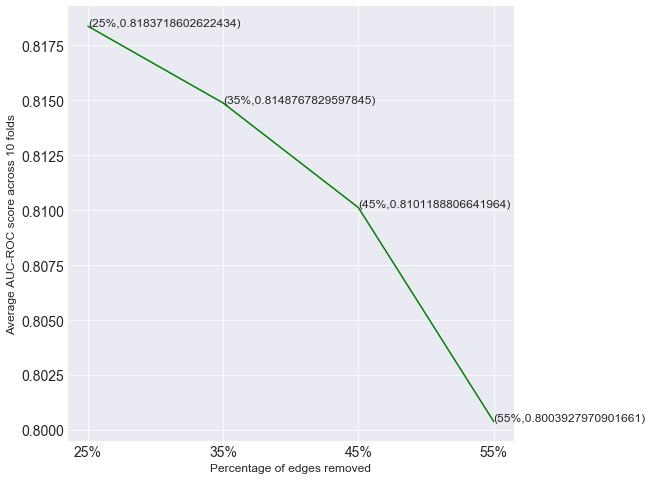

In [20]:
list_heuristics = ['Common neighbours', 'Jaccard Index', 'Adamic Adar index', 'Preferential attachment']
for y in range(len(list_heuristics)):
    print(f"\nPlot using heuristics as {list_heuristics[y]}")
    make_plot(list_avg_auc_roc[y])
# print(list_avg_auc_roc)

In [21]:
list_heuristics = ['Common neighbours', 'Jaccard Index', 'Adamic Adar index', 'Preferential attachment']
list_per = [25, 35, 45, 55]
for heur in range(len(list_heuristics)):
    print(f"\nUsing heuristic as {list_heuristics[heur]}")
    for per in range(len(list_per)):
        print(f"10 fold average ROC-AUC score on removing {list_per[per]}% of edges = {list_avg_auc_roc[heur][per]} ")


Using heuristic as Common neighbours
10 fold average ROC-AUC score on removing 25% of edges = 0.8722984009713959 
10 fold average ROC-AUC score on removing 35% of edges = 0.8433461604141956 
10 fold average ROC-AUC score on removing 45% of edges = 0.8063422738841799 
10 fold average ROC-AUC score on removing 55% of edges = 0.7592960716193723 

Using heuristic as Jaccard Index
10 fold average ROC-AUC score on removing 25% of edges = 0.8624185479259647 
10 fold average ROC-AUC score on removing 35% of edges = 0.8350789866160114 
10 fold average ROC-AUC score on removing 45% of edges = 0.7992960629134211 
10 fold average ROC-AUC score on removing 55% of edges = 0.7540838876024704 

Using heuristic as Adamic Adar index
10 fold average ROC-AUC score on removing 25% of edges = 0.8763719284403244 
10 fold average ROC-AUC score on removing 35% of edges = 0.8466656869067036 
10 fold average ROC-AUC score on removing 45% of edges = 0.809590217829998 
10 fold average ROC-AUC score on removing 55